In [1]:
import numpy as np
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel

from matplotlib import pyplot as plt
import os

/Users/xiangtiange/opt/miniconda3/envs/chris/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
root = '...' # **YOUR ROOT OF DENOISED DATA**
denoised_data = {}

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
data, affine = load_nifti(hardi_fname)
raw_max =  np.max(data, axis=(0,1,2), keepdims=True)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)

# non b0 mask
sel_b = bvals != 0
b0_size = 10

# create a new gradient table on non b0 directions
gtab = gradient_table(bvals[sel_b], bvecs[sel_b])
raw_gtab = gradient_table(bvals, bvecs)

# PLEASE DOUBLE CHECK THE PATH BELOW
# THE DENOISED DATA MUST CONTAIN B0 DIRETCIONS!!
denoised_data['n2s'], _ = load_nifti(root + 'n2s_denoised.nii.gz')
denoised_data['n2n'], _ = load_nifti(root + 'n2n_denoised.nii.gz')
denoised_data['dip'], _ = load_nifti(root + 'dip_denoised.nii.gz')
denoised_data['p2s'], _ = load_nifti(root + 'p2s_denoised.nii.gz')
denoised_data['our'], _ = load_nifti(root + 'ours_denoised.nii.gz')

# normalize denoised data
for k in denoised_data.keys():
    denoised_data[k] -= np.min(denoised_data[k], axis=(0,1), keepdims=True)
    denoised_data[k] /= np.max(denoised_data[k], axis=(0,1), keepdims=True)
    denoised_data[k] = np.concatenate((data[:,:,:,:b0_size], denoised_data[k]), axis=-1)

print('Data loading done!')


In [5]:
print('Computing brain mask...')
b0_mask, mask = median_otsu(data, vol_idx=[0])

print('Computing tensors...')
tenmodel = TensorModel(raw_gtab)
tensorfit = tenmodel.fit(data, mask=mask)

Computing brain mask...
Computing tensors...


Computing worst-case/best-case SNR using the corpus callosum...
(81, 106, 76)


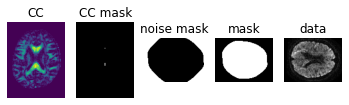

In [6]:
print('Computing worst-case/best-case SNR using the corpus callosum...')
from dipy.segment.mask import segment_from_cfa
from dipy.segment.mask import bounding_box

threshold = (0.6, 1, 0, 0.1, 0, 0.1)

CC_box = np.zeros_like(data[..., 0])

mins, maxs = bounding_box(mask)
mins = np.array(mins)
maxs = np.array(maxs)
diff = (maxs - mins) // 4
bounds_min = mins + diff
bounds_max = maxs - diff

CC_box[bounds_min[0]:bounds_max[0],
       bounds_min[1]:bounds_max[1],
       bounds_min[2]:bounds_max[2]] = 1

mask_cc_part, cfa = segment_from_cfa(tensorfit, CC_box, threshold,
                                     return_cfa=True)


import matplotlib.pyplot as plt

region = 40

# visualize the masks and ROI
fig = plt.figure('Corpus callosum segmentation')
plt.subplot(1, 5, 1)
plt.title("CC")
plt.axis('off')
red = cfa[..., 0]
plt.imshow(np.rot90(red[...,region]))

plt.subplot(1, 5, 2)
plt.title("CC mask")
plt.axis('off')
plt.imshow(np.rot90(mask_cc_part[...,region]), cmap='gray')

from scipy.ndimage.morphology import binary_dilation
mask_noise = binary_dilation(mask, iterations=10)

mask_noise = ~mask_noise
print(mask_noise.shape)

plt.subplot(1, 5, 3)
plt.title("noise mask")
plt.axis('off')
plt.imshow(mask_noise[:,:,40], cmap='gray')

plt.subplot(1, 5, 4)
plt.title("mask")
plt.axis('off')
plt.imshow(mask[:,:,40], cmap='gray')


plt.subplot(1, 5, 5)
plt.title("data")
plt.axis('off')
plt.imshow(data[:,:,40,40], cmap='gray')

In [7]:
# normalize raw data for metric computation
data_normalized = data - np.min(data, axis=(0,1), keepdims=True)
data_normalized = (data_normalized.astype(np.float32) / np.max(data_normalized, axis=(0,1), keepdims=True))

In [8]:
mean_signal = np.mean(data_normalized[mask_cc_part], axis=0)
noise_std = np.std(data_normalized[mask_noise, :], axis=0)
mean_bg = np.mean(data_normalized[mask_noise, :], axis=0)

mean_signal_denoised = {}
denoised_noise_std = {}
denoised_mean_bg = {}

# normalize denoised data for metric calculation
for k, v in denoised_data.items():
    mean_signal_denoised[k] = np.mean(v[mask_cc_part], axis=0)
    denoised_noise_std[k] = np.std(v[mask_noise, :], axis=0)
    denoised_mean_bg[k] = np.mean(v[mask_noise, :], axis=0)

In [9]:
# metric calculation starts here

SNRs = {}
CNRs = {}

SNR = mean_signal / noise_std
CNR = (mean_signal - mean_bg) / noise_std

SNR = SNR[sel_b]
CNR = CNR[sel_b]

SNRs['raw'] = SNR
CNRs['raw'] = CNR

print('raw', '[SNR] mean: %.4f std: %.4f' % (np.mean(SNR), np.std(SNR)))
print('raw', '[CNR] mean: %.4f std: %.4f' % (np.mean(CNR), np.std(CNR)))

for k in denoised_data.keys():
    SNR = mean_signal_denoised[k] / (denoised_noise_std[k]+1e-7)
    CNR = (mean_signal_denoised[k] - denoised_mean_bg[k]) / (denoised_noise_std[k]+1e-7)

    SNR = SNR[sel_b]
    CNR = CNR[sel_b]
    SNR -= SNRs['raw']
    CNR -= CNRs['raw']
    SNRs[k] = SNR
    CNRs[k] = CNR
    print("=================")
    print(k, '[SNR delta] mean: %.4f std: %.4f best: %.4f worst: %.4f' % (np.mean(SNR), np.std(SNR), np.max(SNR), np.min(SNR)))
    print(k, '[CNR delta] mean: %.4f std: %.4f best: %.4f worst: %.4f' % (np.mean(CNR), np.std(CNR), np.max(CNR), np.min(CNR)))

raw [SNR] mean: 5.1141 std: 2.4988
raw [CNR] mean: 4.6567 std: 2.4976
n2s [SNR delta] mean: -0.5301 std: 0.7778 best: 0.5438 worst: -2.9176
n2s [CNR delta] mean: -0.5535 std: 0.7710 best: 0.5077 worst: -2.9232
n2n [SNR delta] mean: 0.8060 std: 2.0059 best: 4.0267 worst: -3.2664
n2n [CNR delta] mean: 0.7942 std: 2.0026 best: 4.0074 worst: -3.2668
dip [SNR delta] mean: -3.0587 std: 1.6048 best: -0.2501 worst: -6.3830
dip [CNR delta] mean: -3.0380 std: 1.6036 best: -0.2839 worst: -6.3900
p2s [SNR delta] mean: 0.1042 std: 0.3641 best: 0.8540 worst: -0.8332
p2s [CNR delta] mean: 0.0748 std: 0.3623 best: 0.8237 worst: -0.8545
our [SNR delta] mean: 1.8284 std: 1.6969 best: 4.9025 worst: -1.7451
our [CNR delta] mean: 1.7486 std: 1.6949 best: 4.8205 worst: -1.8113


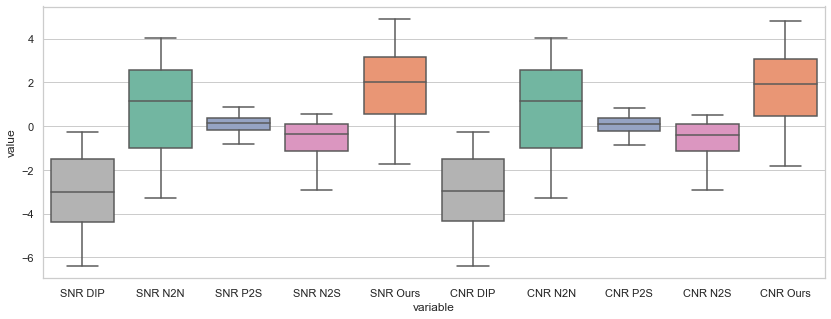

In [10]:
%matplotlib inline
import scipy.stats as stats
import pandas as pd

df_diff = pd.DataFrame({'SNR DIP':SNRs['dip'],
                        'SNR N2N':SNRs['n2n'],
                        'SNR P2S':SNRs['p2s'],
                        'SNR N2S':SNRs['n2s'],
                        'SNR Ours': SNRs['our'],
                        'CNR DIP':CNRs['dip'],
                        'CNR N2N':CNRs['n2n'],
                        'CNR P2S':CNRs['p2s'],
                        'CNR N2S':CNRs['n2s'],
                        'CNR Ours': CNRs['our']})

import seaborn as sns
sns.set(rc={'figure.figsize':(14,5)})
sns.set(style="whitegrid")
set2 = sns.color_palette('Set2')
my_pal = {"SNR DIP": set2[-1], "SNR N2N": set2[0], "SNR P2S": set2[2], "SNR N2S": set2[3], "SNR Ours": set2[1],
          "CNR DIP": set2[-1], "CNR N2N": set2[0], "CNR P2S": set2[2], "CNR N2S": set2[3], "CNR Ours": set2[1]}

ax = sns.boxplot( x="variable", y="value", data=pd.melt(df_diff), fliersize=0, sym='', palette=my_pal)

# plt.savefig('quantitative.svg', dpi=500, bbox_inches='tight')
plt.show()